Topic: "Application of reinforcement learning"

# 1. Goal of the project

The goal of the project was to apply reinforcement learning to some problem. It was said that the students are strongly
encouraged to choose a topic that they would like to learn about, rather than a topic they are familiar with. I had
no previous experience with reinforcement learning and I find this type of machine learning especially interesting
due to its possible applications, therefore I had decided to try to use it and above all gain some general and practical knowledge of this domain.

At first I have decided to learn an agent to play the once very popular 2048 game.

# 2. Implementing 2048 game environment for reinforcement learning

-Rules:
1. At the beginning a square board of size 4x4 containing two randomly placed numbers (each of value 2 or 4) and 14 empty spaces appear.
2. User can move all of the numbers (simultaneously) to any of the edges. If the move caused collision of two equal numbers, they merge into one number being their sum. The total score gets increased by the value of that sum.
3. After each move, new 2 or 4 number is spawned at random place.
4. The game ends when there are no possible moves.

The game is available here: https://play2048.co

The environment for the reinforcement learning should consist of: <br>-action and observation spaces,<br>-a function to check if the game is over,  <br>-reset function which will restart the game once it's over, <br>-step function which should take as an input the action (move) and return the next state, reward for the move, information about game completion and optionally some additional information,
<br>-functions to make actions,<br>-optionally a render function which displays the game state.

In [125]:
import random
import copy
import numpy as np
from gym import spaces


#2048 game environment class. Generally (gym library approach) it should consist of functions to reset the game, render (print)
#the game state and a step function which returns the new state, reward and info if the game is over
class game2048():
    def __init__(self):
        #The game matrix is always 4x4
        self.rows=4
        self.cols=4
        self.reset()
        #The environment for reinforcement learning should have action and observation spaces defined.
        #Action space are all possible moves and usually they are represented as numbers from 0 to -1 + number of possible moves
        self.action_space=spaces.Discrete(4)
        self.observation_space=spaces.Discrete(4**2)
        self.score=0
        
        #While learning, at the end of each episode, the game environment should be reseted
    def reset(self):
        #Preparing an empty board
        self.board = [[0 for x in range(self.cols)] for y in range(self.rows)]
        #At the game start, the matrix is filled with 2 numbers (0s represent empty spaces)
        self.fill()
        self.fill()
        self.score=0
        return self.board
        
        #Function to add 2 or 4 to board. Number 2 spawns with probability = 0.9, 4 with p = 1 - 0.9 = 0.1
    def fill(self):
        empty_indexes = []
        for i, row in enumerate(self.board):
            for j, val in enumerate(row):
                if val == 0:
                    #number can be added only to an empty space
                    empty_indexes.append([i, j])
        #choosing 2 empty spaces randomly
        x,y=random.choice(empty_indexes)
        #assigning numbers
        self.board[x][y]=2 if random.random()<=0.9 else 4
        
        #The game ends when there are no possible moves
    def is_gameover(self):
        for r in self.board:
            #if empty space exists -> possible move
            if r.count(0):
                return False
            #if there exist 2 same elements in neighboring columns -> possible move
            for i in range(self.cols - 1):
                if r[i] == r[i + 1]:
                    return False
        for c in range(self.cols - 1):
            for r in range(self.rows - 1):
                #if there exist 2 same elements in neighboring rows -> possible move
                if self.board[r][c] == self.board[r + 1][c]:
                    return False
        #else game over
        return True

    def left(self):
        #First we go through the board and move any tiles that are in the way of other tiles
        for n in range(self.cols - 1):
            for r in self.board:
                for c in range(self.cols - 1):
                    if 0 == r[c]:
                        r[c] = r[c + 1]
                        r[c + 1] = 0
        #Then we go through the board again and if we find a collision 
        #of equal tiles, we merge them and double the value
        for r in self.board:
            for c in range(self.cols - 1):
                if r[c] == r[c + 1]:
                    r[c] *= 2
                    self.score+=r[c]
                    r[c + 1] = 0
                    
        #We go through the board again same way as at the beginning
        for n in range(self.cols - 1):
            for r in self.board:
                for c in range(self.cols - 1):
                    if 0 == r[c]:
                        r[c] = r[c + 1]
                        r[c + 1] = 0

    #moving right is basically moving left but reversed
    def right(self):
        for r in self.board:
            r.reverse()
        act = self.left()
        for r in self.board:
            r.reverse()
        return act

    #it works same way as moving left
    def up(self):
        for n in range(self.rows - 1):
            for c in range(self.cols):
                for r in range(self.rows - 1):
                    if 0 == self.board[r][c]:
                        self.board[r][c] = self.board[r + 1][c]
                        self.board[r + 1][c] = 0

                        
        for c in range(self.cols):
            for r in range(self.rows - 1):
                if self.board[r][c] == self.board[r + 1][c]:
                    self.board[r][c] *= 2
                    self.score+=self.board[r][c]
                    self.board[r + 1][c] = 0

                    
        for n in range(self.rows - 1):
            for c in range(self.cols):
                for r in range(self.rows - 1):
                    if 0 == self.board[r][c]:
                        self.board[r][c] = self.board[r + 1][c]
                        self.board[r + 1][c] = 0

    #same case as with moving right
    def down(self):
        self.board.reverse()
        act = self.up()
        self.board.reverse()
        return act
    
    #designed to print the game state, using it while learning causes lagging
    def render(self):
        for i in self.board:
            print(i)
    
    #takes an action as an input and returns the new state, reward of the action and the information if the game is over (done)
    def step(self, action):
        prev_score=self.score
        prev_state=copy.deepcopy(self.board)
        possible_actions=[0,1,2,3]
        if action==0:
            self.left()
        elif action==1:
            self.up()
        elif action==2:
            self.right()
        elif action==3:
            self.right
        else:
            self.render()
            #return "wrong input"
        
        while prev_state==self.board:
            
            #both random agent and other agents sometimes tend to choose the actions that are invalid
            #for example when the board looks like this:
            #
            #               [2, 0, 0, 0]
            #               [0, 0, 0, 0]
            #               [4, 0, 0, 0]
            #               [2, 0, 0, 0]
            #
            #and the agent decides to go left, no move is done. I tried many approaches, including penalizing
            #the agent for selecting this kind of actions, but it didn't really help
            #eventually i have decided to temporarily keep removing those actions 
            #from the action space and make random choice from the rest of possible actions
            #surely not a perfect approach though
            
            possible_actions.remove(action)
            if len(possible_actions)==0:
                reward=0
                state=np.array(prev_state)
                done=True
                return state, reward, done, action
            
            action=random.choice(possible_actions)
            if action==0:
                self.left()
            elif action==1:
                self.up()
            elif action==2:
                self.right()
            elif action==3:
                self.right
                
        self.fill()
        #self.render()
        state=np.array(self.board)
        reward=self.score-prev_score
        done=self.is_gameover()
        return state, reward, done, []

# 3. Random agent (no learning)

In [126]:
env = game2048()
num_episodes = 50000
total_scores=[]
max_values=[]
total_steps=[]
for i in range(0, num_episodes):
    t = 0
    #environment needs to be resetted in the beginning of every episode
    env.reset()
    while True:
        t += 1
        #env.render()  => hidden cause lagging
        
        #random action
        action = env.action_space.sample()
        #monitoring the environment after each step
        observation, reward, done, _= env.step(action)
        #limited steps to 1000 because of earlier tendency to get stuck selecting invalid moves,
        #this is fixed now and the game should be finished (done) much faster than that
        if done or t==1000:
            total_scores.append(env.score)
            max_values.append(max(max(sublist) for sublist in env.board))
            total_steps.append(t+1)
            break
#env.close()

## Results

In [153]:
print(f"Average total score after {num_episodes} random games: {np.mean(total_scores)}")
print(f"Max total score of {num_episodes} random games: {np.max(total_scores)}")
print(f"Average number of steps after {num_episodes} random games: {np.mean(total_steps)}")
print(f"Max total number of steps of {num_episodes} random games: {np.max(total_steps)}")
print(f"Average max value after {num_episodes} random games: {np.mean(max_values)}")
print(f"The highest max value after {num_episodes} random games: {np.max(max_values)}, occured {max_values.count(np.max(max_values))} times")

Average total score after 50000 random games: 1384.516
Max total score of 50000 random games: 7224
Average number of steps after 50000 random games: 142.27278
Max total number of steps of 50000 random games: 497
Average max value after 50000 random games: 123.40992
The highest max value after 50000 random games: 512, occured 293 times


Text(0.5, 1.0, 'Histogram of total scores')

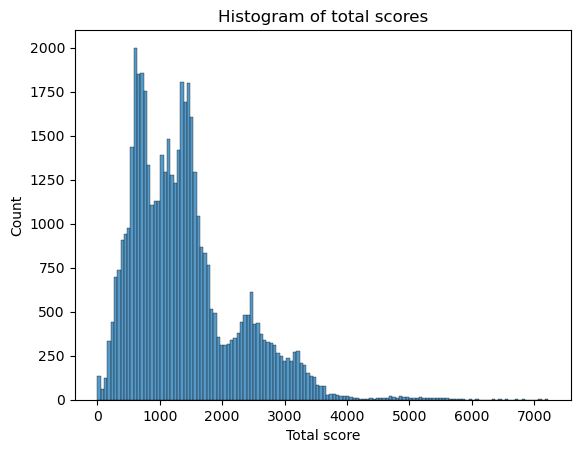

In [154]:
import seaborn as sns
sns.histplot(total_scores)
plt.xlabel("Total score")
plt.title("Histogram of total scores")

Text(0.5, 1.0, 'Histogram of total steps')

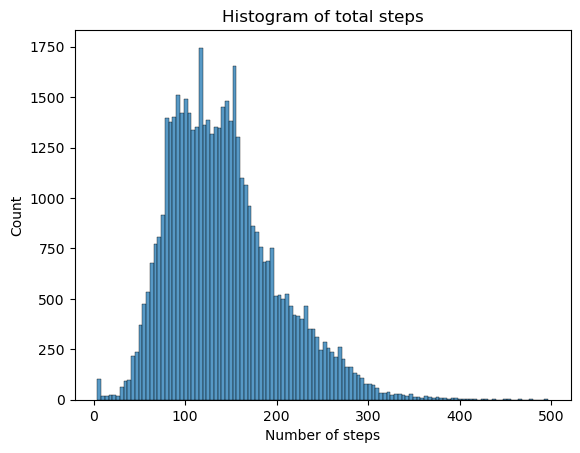

In [148]:
sns.histplot(total_steps)
plt.xlabel("Number of steps")
plt.title("Histogram of total steps")

## Results summary

Statistics after 50000 random games: <br>-mean total score - 1384.516, <br>-mean steps - 142.27278, <br>-mean max value - 123.40992.
<br>Best result was a 7224 score with max value 512 and 497 steps. I will use those stats to analyze RL agent's performance later.

# 4. Q learning approach

The agent learns the optimal policy by using a quality metric called the Q-value. The Q-value is a measure of the expected rewards that the agent will receive if it takes a certain action in a given state. The agent then uses this Q-value to determine the best action to take in a given state. The agent continues to update its Q-value as it interacts with the environment, eventually converging on an optimal policy.

In [ ]:
#Reinforcement Learning Agent Code
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.Q = dict()
        
        #HAVE TRIED MULTIPLE COMBINATIONS OF PARAMETERS BELOW
        self.alpha = 0.2 #learning rate
        self.gamma = 0.1 #discount factor
        self.epsilon = 0.6 #exploration rate
        self.number_of_exploration=0
        self.exploration_limit=1000
        
        
        #takes in a state and returns a string representing the state
        #this string is used as a key in the Q dictionary
    def get_state_key_str(self, state):
        key_str = ''
        for row in state:
            key_str += ''.join([str(x) for x in row])
        return key_str
    
        #takes in a state and an action and returns the Q value for that state-action pair.
    def get_Q_value(self, state, action):
        key_str = self.get_state_key_str(state)
        if key_str not in self.Q:
            self.Q[key_str] = [0 for _ in range(self.action_size)]
        return self.Q[key_str][action]
    
    
        #takes in a state, action, reward, and next state and updates 
        #the Q value for the state-action pair using the Bellman equation
    def update_Q_value(self, state, action, reward, next_state):
        key_str = self.get_state_key_str(state)
        if key_str not in self.Q:
            self.Q[key_str] = [0 for _ in range(self.action_size)]
        self.Q[key_str][action] = (1-self.alpha)*self.get_Q_value(state, action)+self.alpha*(reward+self.gamma*self.get_max_Q_value(next_state))
    
        #takes in a state and returns the maximum Q value for that state
    def get_max_Q_value(self, state):
        key_str = self.get_state_key_str(state)
        if key_str not in self.Q:
            self.Q[key_str] = [0 for _ in range(self.action_size)]
        return max(self.Q[key_str])
    
        #takes in a state and returns an action. It uses an epsilon-greedy approach, 
        #meaning it will explore a random action with probability epsilon, 
        #and otherwise take the action with the highest Q value
    def get_action(self, state):
        if random.random() < self.epsilon and self.number_of_exploration<self.exploration_limit:
            return random.randrange(self.action_size)
        else:
            return self.get_max_Q_action(state)
    
    
    #takes in a state and used to get the action with the maximum Q value for a given state
    def get_max_Q_action(self, state):
        key_str = self.get_state_key_str(state)
        if key_str not in self.Q:
            self.Q[key_str] = [0 for _ in range(self.action_size)]
        max_val = max(self.Q[key_str])
        max_action_list = [x for (x, y) in enumerate(self.Q[key_str]) if y == max_val]
        return random.choice(max_action_list)
    
    
    def learn(self):
        state = self.env.reset()
        done = False
        while not done:
            new_actions=[0,1,2,3]
            action = self.get_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.update_Q_value(state, action, reward, next_state)
            state = next_state
        #self.env.render()

## Learning

In [ ]:
agent = Agent(game2048())
scores=[]
#learning
for i in range(10000):
    agent.number_of_exploration=i
    agent.learn()
    scores.append(agent.env.score)

print("Final Score: ", agent.env.score)

## Results

Generally no improvement has been noticed after Q learning. The reason might be wrong choice of parameters, too low number of episodes or simply the Q learning limitations (it is model-free). Unfortunatelly I didn't save any results as I was hoping I would manage to improve my agent and make him achieve some proper results. Eventually I didn't make it and the learning process was taking long time so I have decided to try some other agent instead.

# 5. Deep Q learning approach

In this approach a deep neural network is used to approximate the action-value (Q) function. It works by taking the current state of the environment and the set of possible actions that can be taken in that state to compute the expected future reward for each action. The action with the highest expected reward is then selected and taken, and the agent receives a reward for taking that action. This reward is then used to update the Q-value for that action and the process is repeated until the agent reaches a goal state or the maximum number of steps are taken.
<br><br>In general there is a special library for deep reinforcement learning called keras-rl2, which allows you to choose one of 5 predefined agents and select their policies. I wanted to use it, but I have faced some troubles importing the agents and for that reason instead of keras agents I am using the below one which might be less efficient.

In [ ]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import gym

class DeepQNAgent:
    
    def __init__(self, model, env, num_episodes, state_size, action_size, gamma=0.95, epsilon=1.0, epsilon_min=0.01, 
                 epsilon_reduction=0.995, learning_rate=0.01, batch_size=64):
        self.model=model
        #self.state_size=env.observation_space.n
        #self.action_space=env.action_space.n
        self.state_size=state_size
        self.action_size=action_size
        self.num_episodes=num_episodes
        #self.state_size=state_size
        #self.action_size=action_size
        self.gamma=gamma  #discount rate
        self.epsilon=epsilon   #exploration rate
        self.epsilon_min=epsilon_min
        self.epsilon_reduction=0.995  # variable to gradually decrease a random exploration 
                                     # rate as the algorithm learns more about the environment
        self.learning_rate=0.01
        self.memory=deque(maxlen=2500)
        self.batch_size=batch_size

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        #returns the index of the maximum value in the act_values variable which is the action to be taken
        return np.argmax(model.predict(state, verbose=0)[0])
        
    #storing the "experience" of the agent    
    def add_to_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def learn_from_exp(self):
        #creates a minibatch of size batch_size from the memory attribute
        minibatch=random.sample(self.memory, self.batch_size)
        #For each array in the minibatch, the target is set to the reward if the state is done
        for state, action, reward, next_state, done in minibatch:
            if done:
                target=reward
            else:
                #otherwise the reward is set to reward + gamma * maximum predicted Q value for next state
                target=reward + self.gamma * max(model.predict(next_state, verbose=0)[0])
            rewards = self.model.predict(state, verbose=0)
            rewards[0][action]=target
            self.model.fit(state, rewards, verbose=0)
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_reduction                    
            
    def learn(self):
        for episode in range(self.num_episodes):
            env.reset()
            done=False
            state=env.reset()
            state=np.reshape(state, (1, state_size))
            total_score=0
            total_scores=[]
            max_vals=[]
            max_steps=1500
            for step in range(max_steps):
                action=self.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                total_score+=reward
                next_state = np.reshape(next_state, (1, self.state_size))
                self.add_to_memory(state, action, reward, next_state, done)
                state = next_state
                if done:
                    print(f"episode: {episode+1}/{self.num_episodes}, total score: {total_score}, max value: {max(state[0])}, steps: {step}")
                    total_scores.append(total_score)
                    break
            #learning from the experience
            if len(self.memory) > self.batch_size:
                self.learn_from_exp()

## Checking the agent's ability to learn playing 2048 game - learning process

In [ ]:
env=game2048()
state_size = env.observation_space.n
action_size = env.action_space.n

model = Sequential()
model.add(Dense(512, input_dim=state_size, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(action_size, activation='linear', kernel_initializer='he_uniform'))
model.compile(loss='mse', optimizer=Adam(lr=0.00025, epsilon=0.01), metrics=["accuracy"])

agent=DeepQNAgent(model=model, env=gym.make('CartPole-v1'), num_episodes=5000, state_size=state_size, action_size=action_size)
agent.learn()

## Analysing the results

In [156]:
path='C://Users//Adam/Desktop//dqn2048.txt'
results=[]
with open(path, 'r') as f:
    for line in f.readlines():
        results.append(line.replace(",","").replace("\n","").split(" "))
print(len(results), results[0])
total_scores=[int(result[4]) for result in results]
max_values=[int(result[-3]) for result in results]
steps=[int(result[-1]) for result in results]

1525 ['episode:', '1/5000', 'total', 'score:', '768', 'max', 'value:', '64', 'steps:', '93']


In [157]:
for i in range(0,1500, 100):
    print(f"The average total score of {i}-{i+100} episodes: {np.mean(total_scores[i:i+100])}")
print("The overall average score:", np.mean(total_scores))

The average total score of 0-100 episodes: 1463.04
The average total score of 100-200 episodes: 1546.8
The average total score of 200-300 episodes: 1502.64
The average total score of 300-400 episodes: 1454.32
The average total score of 400-500 episodes: 1785.56
The average total score of 500-600 episodes: 1326.8
The average total score of 600-700 episodes: 1570.68
The average total score of 700-800 episodes: 1626.52
The average total score of 800-900 episodes: 1687.16
The average total score of 900-1000 episodes: 1660.12
The average total score of 1000-1100 episodes: 1399.2
The average total score of 1100-1200 episodes: 1408.4
The average total score of 1200-1300 episodes: 1959.32
The average total score of 1300-1400 episodes: 1579.6
The average total score of 1400-1500 episodes: 1550.68
The overall average score: 1574.5888524590164


In [158]:
print("Episodes 0-500:")
print(f"Average max value: {np.mean(max_values[:500])} \nAverage total score: {np.mean(total_scores[:500])}\nAverage total steps: {np.mean(steps[:500])}")
print("\nEpisodes 500+:")
print(f"Average max value: {np.mean(max_values[500:])} \nAverage total score: {np.mean(total_scores[500:])}\nAverage total steps: {np.mean(steps[500:])}")

Episodes 0-500:
Average max value: 136.408 
Average total score: 1550.472
Average total steps: 150.882

Episodes 500+:
Average max value: 139.3990243902439 
Average total score: 1586.3531707317072
Average total steps: 152.73268292682926


In [159]:
best=np.argmax(total_scores)
print(f"Best attempt's total score: {total_scores[best]} / max value: {max_values[best]} / total steps: {steps[best]} / index: {best}")

Best attempt's total score: 9628 / max value: 1024 / total steps: 546 / index: 900


In [160]:
arr = total_scores
window_size = 100
i = 0
moving_averages = []
while i < len(arr) - window_size + 1:
    window_average = round(np.sum(arr[
      i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1

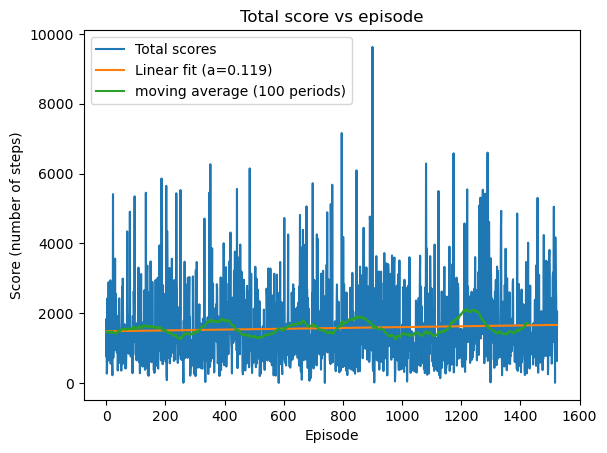

In [161]:
import matplotlib.pyplot as plt
X=range(len(steps))
plt.plot(X, total_scores)
a, b = np.polyfit(X, total_scores, 1)
plt.plot(X, a*X + b)
plt.xlabel("Episode")
plt.ylabel("Score (number of steps)")
plt.yscale
plt.plot(range(len(moving_averages)), moving_averages)
plt.title('Total score vs episode')
plt.legend(['Total scores','Linear fit (a=0.119)','Moving average (100 periods)'])
plt.show()

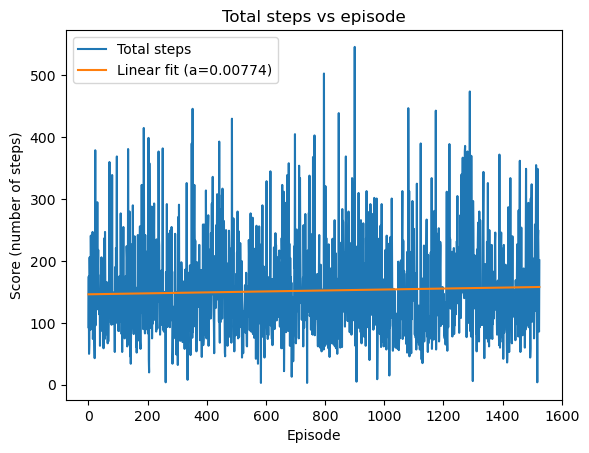

In [162]:
import matplotlib.pyplot as plt
X=range(len(steps))
plt.plot(X, steps)
a, b = np.polyfit(X, steps, 1)
plt.plot(X, a*X + b)
plt.xlabel("Episode")
plt.ylabel("Score (number of steps)")
plt.yscale
plt.title('Total steps vs episode')
plt.legend(['Total steps','Linear fit (a=0.00774)'])
plt.show()

Text(0.5, 1.0, 'Histogram of total scores')

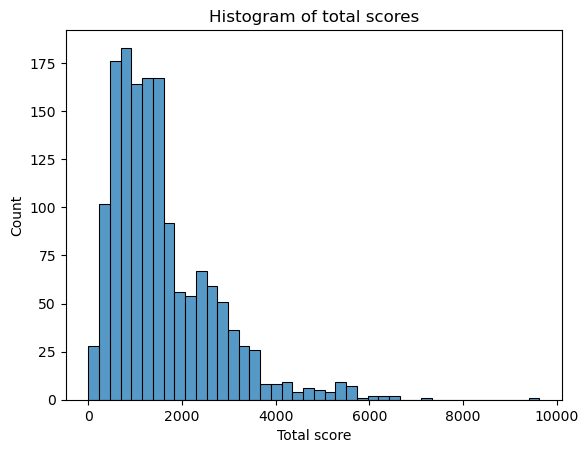

In [167]:
sns.histplot(total_scores)
plt.xlabel("Total score")
plt.title("Histogram of total scores")

Text(0.5, 1.0, 'Histogram of total steps')

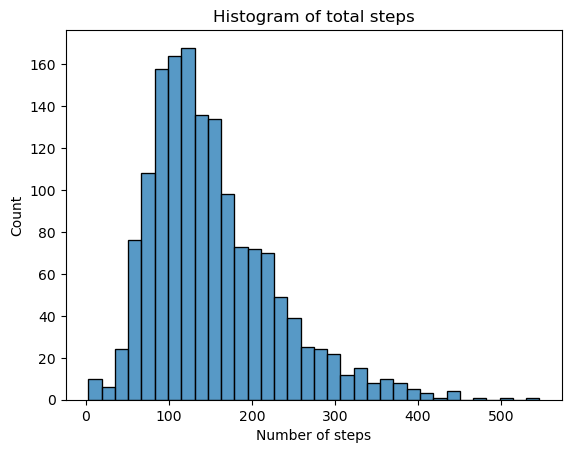

In [168]:
sns.histplot(steps)
plt.xlabel("Number of steps")
plt.title("Histogram of total steps")

## Results summary

The agent was trained for over 1500 episodes. The learning process was very slow. The improvement can be noticed, but is extremely low. The histograms of total scores and total steps look very similar to the same histograms for a random agent. The average values of total scores, total steps, max values in the end were higher than the values from the beginning and higher compared to the random agent results, however the difference is insignificant.

<br>Comparing the values (random vs DQN after 500 episodes):
<br>Average total score: 1384.5 - 1586.3
<br>Average number of steps: 142.3 - 152.7
<br>Average max value: 123.4 - 139.4
<br>Max total score: 7224 - 9628
<br>Max total number of steps: 497 - 546
<br>Max value: 512 - 1024
<br>In random games the max value occured 293 times out of 50000 played - so the ratio is 0.00586. On the other hand the DQN agent achieved this value 39 times out of 1512 games played, so the frequency is 4.36 times higher for DQN.

<br>There is improvement, but the general performance is still very unsatisfying - a person who has never played this game can easily beat the agent. Maybe changing the approach and for example making the agent play more episodes with smaller steps limit (not playing till done - like the way before) could make him learn more and learn faster. Maybe using more complex networks and more episodes could be the solution.

# 6. Same agent for Cart-Pole game

Since the agents have more or less failed learning to play 2048 game, I have decided to make them try something that I believe is simpler. That way I could at least determine whether the agents are in general badly scripted and maybe some theoretical stuff inside them was badly implemented or if my game environment was the problem (its implementation or/and complexity). For this purpose I have decided to try the Cart-Pole game which I guess is something like the Iris dataset for supervised learning - quite a simple and very basic problem. The environment is already included in gym library. There are 2 possible actions (left / right) and the observation state consists of 4 continuous elements which are cart position, cart velocity, pole angle and pole angular velocity. The goal if this game is to keep the the cart-pole balanced as long as possible.
You can read about this game here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

## Learning process

In [ ]:
env=gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = Sequential()
model.add(Dense(512, input_dim=state_size, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(action_size, activation='linear', kernel_initializer='he_uniform'))
model.compile(loss='mse', optimizer=Adam(lr=0.00025, epsilon=0.01), metrics=["accuracy"])

agent=DeepQNAgent(model=model, env=gym.make('CartPole-v1'), num_episodes=5000, state_size=state_size, action_size=action_size)
agent.learn()

## Analysing the results

In [115]:
path='C://Users//Adam/Desktop//dqncartpole.txt'
results=[]
with open(path, 'r') as f:
    for line in f.readlines():
        results.append(line.replace("\n","").split(" "))

['episode:', '1/600,', 'total', 'score:', '16.0']

In [117]:
steps=[float(result[-1]) for result in results]

In [120]:
print(f"The average score of 0-100 episodes: {np.mean(steps[:100])}")
print(f"The average score of 100-200 episodes: {np.mean(steps[100:200])}")
print(f"The average score of 200-300 episodes: {np.mean(steps[200:300])}")
print(f"The average score of 300-400 episodes: {np.mean(steps[300:400])}")
print(f"The average score of 400-500 episodes: {np.mean(steps[400:500])}")
print(f"The average score of 500-600 episodes: {np.mean(steps[500:])}")

The average score of 0-100 episodes: 16.48
The average score of 100-200 episodes: 34.14
The average score of 200-300 episodes: 84.49
The average score of 300-400 episodes: 153.03
The average score of 400-500 episodes: 203.74
The average score of 500-600 episodes: 296.17


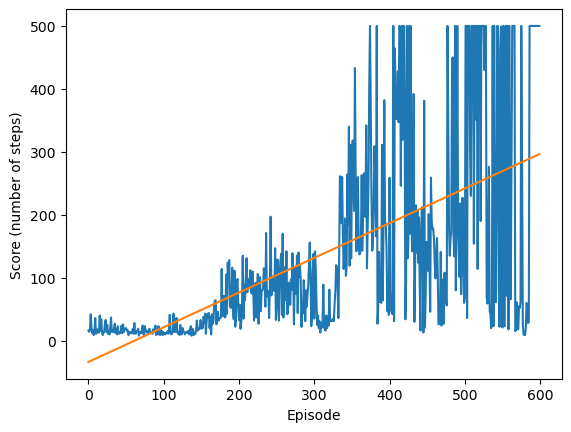

In [124]:
import matplotlib.pyplot as plt
X=range(len(steps))
plt.plot(X, steps)
a, b = np.polyfit(X, steps, 1)
plt.plot(X, a*X + b)
plt.xlabel("Episode")
plt.ylabel("Score (number of steps)")
plt.show()

## Result summary

Now it can be seen how the performance improved with episodes. The progress is easily visible. The agent has achieved the maximum possible score (500) multiple times. Due to the smaller action and observation spaces, the learning process was quite fast, therefore training for higher number of episodes and achieving even better results should not be problematic. Also using some less complex networks should still provide good results.

# 7. References

1. https://play2048.co
2. https://www.gymlibrary.dev/environments/classic_control/cart_pole/
3. https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc